# ESRGAN
Notebook to reproduce the results of https://openaccess.thecvf.com/content_ECCVW_2018/papers/11133/Wang_ESRGAN_Enhanced_Super-Resolution_Generative_Adversarial_Networks_ECCVW_2018_paper.pdf following https://medium.com/analytics-vidhya/super-resolution-gan-srgan-5e10438aec0c 

In [1]:
!git clone https://github.com/vishal1905/Super-Resolution.git

fatal: destination path 'Super-Resolution' already exists and is not an empty directory.


In [3]:
import os
import torch
import torch.nn as n
import torch.nn.functional as f
import numpy as np
import os
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm
from torchvision import models
import torchvision
import cv2
from matplotlib import pyplot as plt
from PIL import Image

cuda = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
base_dir = "Super-Resolution/celeba-dataset/img_align_celeba/img_align_celeba/"
images = os.listdir(base_dir)
imageList = images[:1500]

## Define generator

In [5]:
class Generator(n.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = n.Conv2d(3,64,9,padding=4,bias=False)
        self.conv2 = n.Conv2d(64,64,3,padding=1,bias=False)
        self.conv3_1 = n.Conv2d(64,256,3,padding=1,bias=False)
        self.conv3_2 = n.Conv2d(64,256,3,padding=1,bias=False)
        self.conv4 = n.Conv2d(64,3,9,padding=4,bias=False)
        self.bn = n.BatchNorm2d(64)
        self.ps = n.PixelShuffle(2)
        self.prelu = n.PReLU()
        
    def forward(self,x):
        block1 = self.prelu(self.conv1(x))
        block2 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block1))))),block1)
        block3 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block2))))),block2)
        block4 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block3))))),block3)
        block5 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block4))))),block4)
        block6 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block5))))),block5)
        block7 = torch.add(self.bn(self.conv2(block6)),block1)
        block8 = self.prelu(self.ps(self.conv3_1(block7)))
        block9 = self.prelu(self.ps(self.conv3_2(block8)))
        block10 = self.conv4(block9)
        return block10

In [6]:
gen = Generator().to(cuda).float()

## Discriminator

In [7]:
class Discriminator(n.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = n.Conv2d(3,64,3,padding=1,bias=False)
        self.conv2 = n.Conv2d(64,64,3,stride=2,padding=1,bias=False)
        self.bn2 = n.BatchNorm2d(64)
        self.conv3 = n.Conv2d(64,128,3,padding=1,bias=False)
        self.bn3 = n.BatchNorm2d(128)
        self.conv4 = n.Conv2d(128,128,3,stride=2,padding=1,bias=False)
        self.bn4 = n.BatchNorm2d(128)
        self.conv5 = n.Conv2d(128,256,3,padding=1,bias=False)
        self.bn5 = n.BatchNorm2d(256)
        self.conv6 = n.Conv2d(256,256,3,stride=2,padding=1,bias=False)
        self.bn6 = n.BatchNorm2d(256)
        self.conv7 = n.Conv2d(256,512,3,padding=1,bias=False)
        self.bn7 = n.BatchNorm2d(512)
        self.conv8 = n.Conv2d(512,512,3,stride=2,padding=1,bias=False)
        self.bn8 = n.BatchNorm2d(512)
        self.fc1 = n.Linear(512*16*16,1024)
        self.fc2 = n.Linear(1024,1)
        self.drop = n.Dropout2d(0.3)
        
    def forward(self,x):
        block1 = f.leaky_relu(self.conv1(x))
        block2 = f.leaky_relu(self.bn2(self.conv2(block1)))
        block3 = f.leaky_relu(self.bn3(self.conv3(block2)))
        block4 = f.leaky_relu(self.bn4(self.conv4(block3)))
        block5 = f.leaky_relu(self.bn5(self.conv5(block4)))
        block6 = f.leaky_relu(self.bn6(self.conv6(block5)))
        block7 = f.leaky_relu(self.bn7(self.conv7(block6)))
        block8 = f.leaky_relu(self.bn8(self.conv8(block7)))
        block8 = block8.view(-1,block8.size(1)*block8.size(2)*block8.size(3))
        block9 = f.leaky_relu(self.fc1(block8),)
        block10 = torch.sigmoid(self.drop(self.fc2(block9)))
        return block9,block10

In [8]:
disc = Discriminator().to(cuda).float()

## Setup training

In [9]:
vgg = models.vgg19(pretrained=True).to(cuda)

### Losses

In [10]:
gen_loss = n.BCELoss()
vgg_loss = n.MSELoss()
mse_loss = n.MSELoss()
disc_loss = n.BCELoss()

In [11]:
gen_optimizer = optim.Adam(gen.parameters(),lr=0.0001)
disc_optimizer = optim.Adam(disc.parameters(),lr=0.0001)

### Load images

### New image loaders

In [12]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False 
    model.eval()
    return model

In [13]:
def imagePostProcess(imagedir, modelPath):
    """
    Show model output on unseen images 
    Parameters:
    ----------
    imagedir: str
        List of paths to unseen images
    
    """
    imagelist=[]
    original_images = []
    for img in imagedir:
        img_original = cv2.imread(os.path.join(hr_path,img))
        img_original = cv2.resize(img_original, (256,256))
        img = degrade_resolution(img_original)
        imagelist.append(img)
        original_images.append(img_original)
    original_images = np.array(original_images)
    imagearray = np.array(imagelist)/255
    imagearrayPT = np.moveaxis(imagearray,3,1)

    model = load_checkpoint(modelPath)
    im_tensor = torch.from_numpy(imagearrayPT).float()
    out_tensor = model(im_tensor)
    out = out_tensor.numpy()
    out = np.moveaxis(out,1,3)
    out = np.clip(out,0,1)
    
    return original_images, imagearray, out

In [14]:
def show_samples(image_dir, model_path):

    # Load images and run through
    original_images, low_res, out = imagePostProcess(image_dir, model_path)

    # Get the number of samples to plot
    n_samples = len(image_dir)
    figure, axes = plt.subplots(n_samples, 3)
    for i in range(n_samples):
        axes[i,0].imshow(original_images[i,...][...,::-1])

    for i in range(n_samples):
        axes[i,1].imshow(low_res[i,...][...,::-1])

    for i in range(n_samples):
        axes[i,2].imshow(out[i,...][...,::-1])
    plt.axis("off")
    plt.show()
    plt.close()

In [15]:
def degrade_resolution(image):
    """
    Degrade image resolution
    """
    resized = cv2.resize(cv2.GaussianBlur(image,(5,5),cv2.BORDER_DEFAULT),(64,64)) 
    return resized

In [16]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'

  def __init__(self, image_list):
        'Initialization'
        self.image_list = image_list
        self.base_dir = "Super-Resolution/celeba-dataset/img_align_celeba/img_align_celeba/"

  def __len__(self):
        return len(self.image_list)

  def __getitem__(self, index):
        # Select sample
        image_file = self.image_list[index]

        # Load the original (high res) image
        high_res = cv2.imread(self.base_dir+image_file)
        high_res = cv2.resize(high_res, (256,256))

        # Degrade to low res
        low_res = degrade_resolution(high_res)

        # Normalise
        high_res = torch.from_numpy(high_res/255)
        low_res = torch.from_numpy(low_res/255)

        # Channels to second dim
        high_res = high_res.permute(2,0,1)
        low_res = low_res.permute(2,0,1)

        return low_res.cuda().float(), high_res.cuda().float()

In [17]:
image_dataset = Dataset(imageList)

In [18]:
training_generator = torch.utils.data.DataLoader(image_dataset,
                                                 shuffle = True,
                                                 batch_size = 32
                                                )

In [19]:
import os 
base_path = os.getcwd()

#lr_path = os.path.join(base_path,"trainImages")
hr_path = base_dir
#valid_path = os.path.join(base_path,"SR_valid")
weight_file = os.path.join(base_path,"SRPT_weights")
out_path = os.path.join(base_path,"out")

if not os.path.exists(weight_file):
    os.makedirs(weight_file)

if not os.path.exists(out_path):
    os.makedirs(out_path)


100%|██████████| 47/47 [00:59<00:00,  1.27s/it]


d1_loss: 0.3824750468768972  d2_loss:0.6241543086919379
genLoss: 21.336436725677327  vggLoss: 0.19265809813712506  MeanLoss: 0.07063404595519


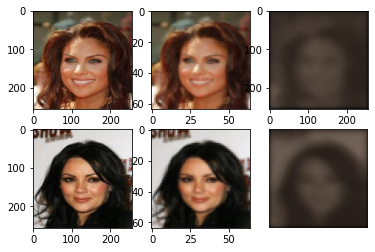

  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.2121499426504399  d2_loss:0.20040724157018863
genLoss: 26.026892540302683  vggLoss: 0.1290102187306323  MeanLoss: 0.012290955778766186


  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.22603600123461257  d2_loss:0.25095811026527526
genLoss: 27.454648768648187  vggLoss: 0.10740499024061446  MeanLoss: 0.0071519206357287595


100%|██████████| 47/47 [00:59<00:00,  1.27s/it]


d1_loss: 0.21152098381772955  d2_loss:0.20132297927394827
genLoss: 29.269397816759476  vggLoss: 0.09084894967840072  MeanLoss: 0.005050146783840783


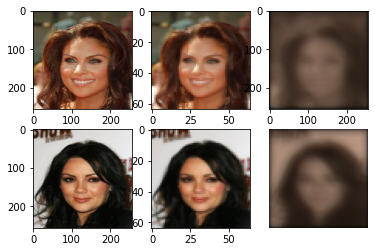

  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.2082496206177042  d2_loss:0.23745346925360092
genLoss: 28.336808793088224  vggLoss: 0.08061944946963737  MeanLoss: 0.004177188773223377


  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.21506946581475278  d2_loss:0.22226751516474055
genLoss: 25.682806806361423  vggLoss: 0.07497543722708175  MeanLoss: 0.0038483570815321614


100%|██████████| 47/47 [00:59<00:00,  1.27s/it]


d1_loss: 0.20040209512127208  d2_loss:0.20848265274408015
genLoss: 25.655304929043385  vggLoss: 0.07107174412367191  MeanLoss: 0.003274976478968846


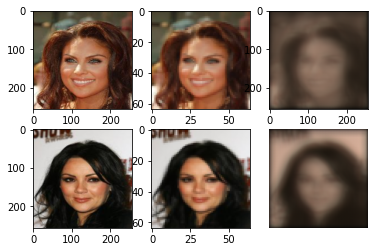

  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.22485288074041934  d2_loss:0.1987451249931721
genLoss: 25.882653134934447  vggLoss: 0.06837674151075647  MeanLoss: 0.002899868725898101


  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.21963730945866158  d2_loss:0.2227977625233062
genLoss: 24.990060481619327  vggLoss: 0.06630812767655292  MeanLoss: 0.0027161984298219705


100%|██████████| 47/47 [00:59<00:00,  1.27s/it]


d1_loss: 0.2089177371656641  d2_loss:0.21660890224132132
genLoss: 23.01881644066344  vggLoss: 0.0646096612227724  MeanLoss: 0.002447352177423841


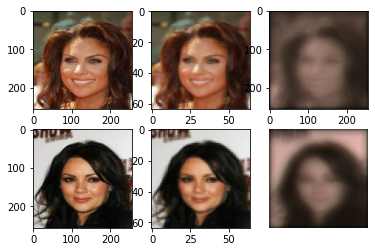

  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 1.1718954868773197  d2_loss:0.34915436503100905
genLoss: 21.93802224892251  vggLoss: 0.06334742776891018  MeanLoss: 0.0022744659379005747


  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.3864877130439941  d2_loss:0.2544790449294638
genLoss: 24.543885991928427  vggLoss: 0.06233944458530304  MeanLoss: 0.0020511604231247243


100%|██████████| 47/47 [00:59<00:00,  1.27s/it]


d1_loss: 0.20666202522338706  d2_loss:0.2101630600208932
genLoss: 19.569110910943213  vggLoss: 0.061384358066827696  MeanLoss: 0.0018974326060530037


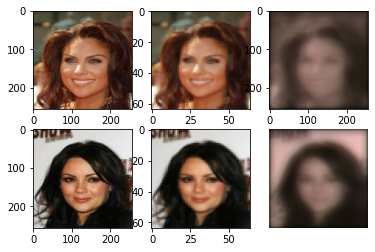

  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.22639102869211358  d2_loss:0.2013237768031181
genLoss: 19.76753198339584  vggLoss: 0.06077746032400334  MeanLoss: 0.001924159869729997


  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.2016277048499026  d2_loss:0.20316618617544782
genLoss: 21.530313735312603  vggLoss: 0.06008531446469591  MeanLoss: 0.0018951133106577588


100%|██████████| 47/47 [00:59<00:00,  1.27s/it]


d1_loss: 0.19097147929541608  d2_loss:0.18942017187463475
genLoss: 20.146309345326525  vggLoss: 0.05952367677967599  MeanLoss: 0.001782575277908844


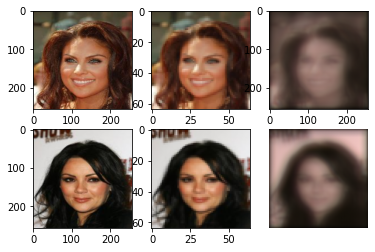

  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.21149920307575387  d2_loss:0.20094021005516358
genLoss: 17.897431677960334  vggLoss: 0.05896141292883995  MeanLoss: 0.0017110772970865698


  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.20817012339830399  d2_loss:0.2073392298944453
genLoss: 18.27227251580421  vggLoss: 0.058360270601003725  MeanLoss: 0.0016049684664393043


100%|██████████| 47/47 [01:00<00:00,  1.28s/it]


d1_loss: 0.19818067946966658  d2_loss:0.2095079669292937
genLoss: 19.917408212702323  vggLoss: 0.05786944133170108  MeanLoss: 0.0015612378533176603


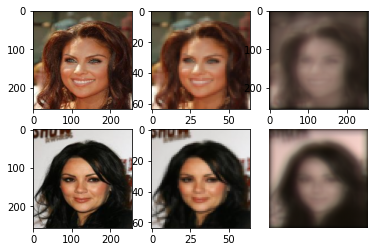

  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.19960148616674098  d2_loss:0.21643588755359042
genLoss: 17.920573498340364  vggLoss: 0.05739335977333657  MeanLoss: 0.0015966756457581799


  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.22082686107209387  d2_loss:0.20800716223868917
genLoss: 17.494238609963276  vggLoss: 0.05699599320267109  MeanLoss: 0.001546598282305801


100%|██████████| 47/47 [01:00<00:00,  1.28s/it]


d1_loss: 0.20506161704976508  d2_loss:0.20798852088603567
genLoss: 16.85829154481279  vggLoss: 0.05649454701454081  MeanLoss: 0.001528926939267586


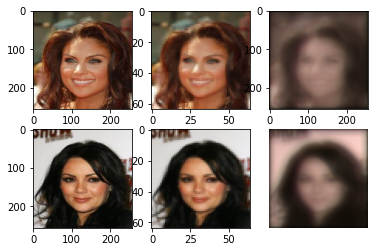

  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.20100558152858247  d2_loss:0.2084862508989395
genLoss: 17.02715798641773  vggLoss: 0.05614682588171452  MeanLoss: 0.0015355738528825818


  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.22307918838998106  d2_loss:0.19620871115872202
genLoss: 15.56273273711509  vggLoss: 0.05562129664294263  MeanLoss: 0.0014334116824605363


100%|██████████| 47/47 [01:00<00:00,  1.28s/it]


d1_loss: 0.20475561219326993  d2_loss:0.21287083847725646
genLoss: 15.565404607894573  vggLoss: 0.05523659875418278  MeanLoss: 0.0014248685960836234


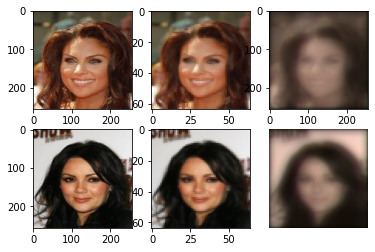

  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.21459794012790032  d2_loss:0.21347508769720158
genLoss: 15.16976967263729  vggLoss: 0.05494988257897661  MeanLoss: 0.00143381472468931


  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.21526869227911563  d2_loss:0.22401475874667473
genLoss: 14.829911739268201  vggLoss: 0.05462182828403534  MeanLoss: 0.0014952077664078234


100%|██████████| 47/47 [01:00<00:00,  1.28s/it]


d1_loss: 0.2355543796686416  d2_loss:0.25076625448592166
genLoss: 13.965174685133265  vggLoss: 0.0541421797998408  MeanLoss: 0.0013554865231816756


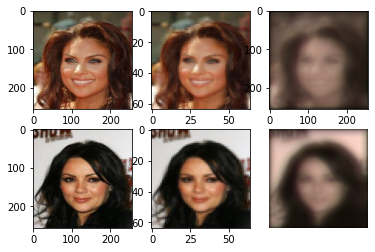

  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.23441527561938508  d2_loss:0.24839080600662433
genLoss: 14.676237045450414  vggLoss: 0.05378610220678309  MeanLoss: 0.0013528011610454067


  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.21414778873007348  d2_loss:0.20359133516854427
genLoss: 17.829282740329173  vggLoss: 0.05343473258804768  MeanLoss: 0.0013224724804031405


100%|██████████| 47/47 [01:00<00:00,  1.28s/it]


d1_loss: 0.19472402904896027  d2_loss:0.19554184678387135
genLoss: 20.16152308849578  vggLoss: 0.05305753394644311  MeanLoss: 0.0012937055781800696


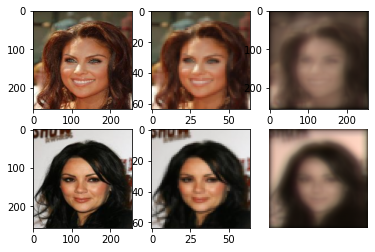

  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.22200745930697055  d2_loss:0.20608531905615585
genLoss: 21.525594995376913  vggLoss: 0.052836030166833955  MeanLoss: 0.001423193798202308


  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.21009081078970687  d2_loss:0.20457298926850584
genLoss: 21.593177146099983  vggLoss: 0.05246365744065731  MeanLoss: 0.0012707184638550623


100%|██████████| 47/47 [01:00<00:00,  1.28s/it]


d1_loss: 0.20363886464149394  d2_loss:0.2073271374436135
genLoss: 21.31703141395082  vggLoss: 0.05211071456049351  MeanLoss: 0.0012553593136389997


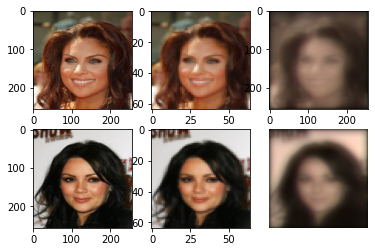

  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.21114473330213668  d2_loss:0.21028902524329246
genLoss: 20.431320170138743  vggLoss: 0.05183952452337488  MeanLoss: 0.0012815178760842599


  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.19185711427571925  d2_loss:0.20739462813164325
genLoss: 20.855395093877267  vggLoss: 0.05154744781395222  MeanLoss: 0.0012941214682019137


100%|██████████| 47/47 [01:00<00:00,  1.28s/it]


d1_loss: 0.20712904235784044  d2_loss:0.21740011078246096
genLoss: 19.540064689960886  vggLoss: 0.05113459204105621  MeanLoss: 0.0011475511685390264


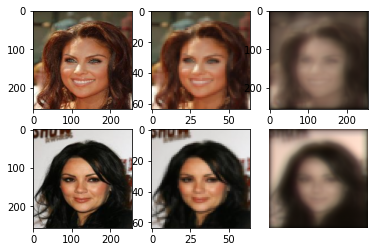

  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.20917707000007021  d2_loss:0.20917132591947596
genLoss: 18.99240319272305  vggLoss: 0.050854310076287455  MeanLoss: 0.0011715123013771595


  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.21213664241293642  d2_loss:0.1994262198184399
genLoss: 18.772211582102674  vggLoss: 0.0506424347453929  MeanLoss: 0.0011609310378379962


100%|██████████| 47/47 [01:00<00:00,  1.28s/it]


d1_loss: 0.2041787251513055  d2_loss:0.20396889666927623
genLoss: 18.63852470479113  vggLoss: 0.050419991082967595  MeanLoss: 0.0012088333766788562


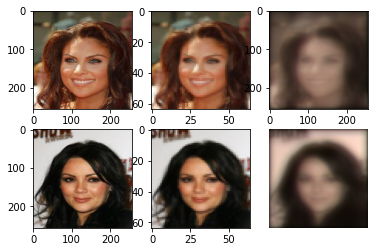

  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.21082625363735444  d2_loss:0.21766675850178333
genLoss: 18.151317312362345  vggLoss: 0.05018109265477099  MeanLoss: 0.0012248231486932553


  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.20930048173412363  d2_loss:0.22373856762622266
genLoss: 21.142408614462994  vggLoss: 0.04987022502625242  MeanLoss: 0.0011278725974757146


100%|██████████| 47/47 [01:00<00:00,  1.28s/it]


d1_loss: 0.20805075970735956  d2_loss:0.1978605901624294
genLoss: 20.260330768341714  vggLoss: 0.049701012670993805  MeanLoss: 0.001214579661733451


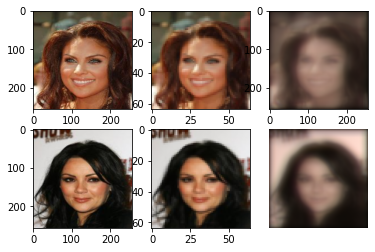

  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.21048719039622774  d2_loss:0.2186514771682151
genLoss: 19.377537646192184  vggLoss: 0.0494916836949105  MeanLoss: 0.0011347654124503916


  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.21407692641653914  d2_loss:0.20192892120239583
genLoss: 19.011983851169017  vggLoss: 0.04934844057610695  MeanLoss: 0.0011777051878062651


100%|██████████| 47/47 [01:00<00:00,  1.28s/it]


d1_loss: 0.21707039215463272  d2_loss:0.19850713926109861
genLoss: 18.85134449410946  vggLoss: 0.04922492429614067  MeanLoss: 0.001160605722651916


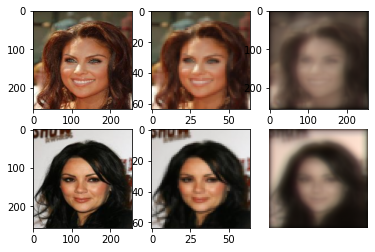

  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.20186350447066287  d2_loss:0.19456392954638663
genLoss: 18.83874211412795  vggLoss: 0.05092764780559438  MeanLoss: 0.0011718808177937853


  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.1921895796314199  d2_loss:0.20897262717815154
genLoss: 19.68820391310022  vggLoss: 0.05068903400542888  MeanLoss: 0.0012480425660775856


100%|██████████| 47/47 [01:00<00:00,  1.28s/it]


d1_loss: 0.203121136477653  d2_loss:0.20430297769130545
genLoss: 18.039799284427723  vggLoss: 0.04886307464318072  MeanLoss: 0.001168987121769881


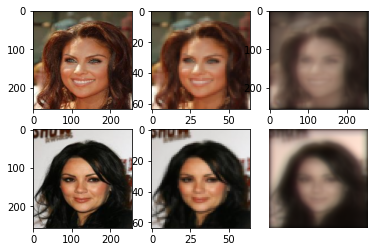

  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.20944832804355215  d2_loss:0.20755143637986892
genLoss: 18.932175108726987  vggLoss: 0.048558539928908045  MeanLoss: 0.0011240246549664818


  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.21109316894348631  d2_loss:0.1993732266920678
genLoss: 18.68842615979783  vggLoss: 0.04842870848927092  MeanLoss: 0.0011140744021023684


100%|██████████| 47/47 [01:00<00:00,  1.28s/it]


d1_loss: 0.27629228411836826  d2_loss:0.2826229863344355
genLoss: 15.69972523729852  vggLoss: 0.04816251636502591  MeanLoss: 0.0010231373747414414


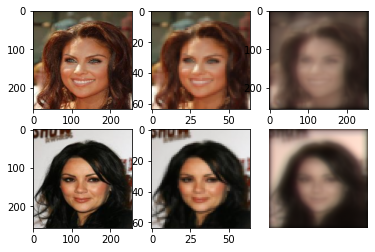

  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.21125614389460137  d2_loss:0.22298135814514566
genLoss: 16.820974918121987  vggLoss: 0.048017965590066096  MeanLoss: 0.0010434742038574149


  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.22228412916685672  d2_loss:0.21148174303643247
genLoss: 18.63027789744925  vggLoss: 0.04785343568692816  MeanLoss: 0.0010216332602988375


100%|██████████| 47/47 [01:00<00:00,  1.28s/it]


d1_loss: 0.21842327571295678  d2_loss:0.21605076244536867
genLoss: 19.032924956463752  vggLoss: 0.04787108864873014  MeanLoss: 0.0010777880819118086


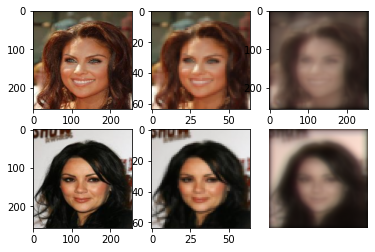

  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.20345251531677044  d2_loss:0.21601918926264377
genLoss: 21.18731143626761  vggLoss: 0.04771512952890802  MeanLoss: 0.0010966179444097935


  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.20851824606986755  d2_loss:0.20640671189795148
genLoss: 20.841744260585056  vggLoss: 0.047582706079838125  MeanLoss: 0.0010168737102735866


100%|██████████| 47/47 [01:00<00:00,  1.28s/it]


d1_loss: 0.20924421922957642  d2_loss:0.19771544001203903
genLoss: 20.915588135414936  vggLoss: 0.047612361372151274  MeanLoss: 0.0010954931705318234


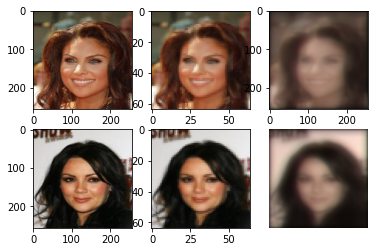

  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.20278917031085236  d2_loss:0.20291593480617443
genLoss: 21.43354446329969  vggLoss: 0.04741608470361283  MeanLoss: 0.0010716349872304722


  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.20232782829949197  d2_loss:0.21298792165644626
genLoss: 21.988906048713847  vggLoss: 0.04731165570147494  MeanLoss: 0.0010682856651676937


100%|██████████| 47/47 [01:00<00:00,  1.28s/it]


d1_loss: 0.19337299006416442  d2_loss:0.2037714199816927
genLoss: 22.031167699935587  vggLoss: 0.047321826536604696  MeanLoss: 0.0010883733766411054


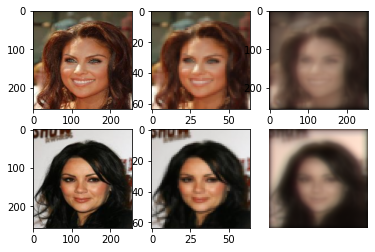

  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.20331375078952058  d2_loss:0.18678667475568486
genLoss: 22.04626087432212  vggLoss: 0.04703538230759032  MeanLoss: 0.0010073419952606583


  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.2105566034925745  d2_loss:0.205881600525785
genLoss: 21.07821450334914  vggLoss: 0.046873816784392015  MeanLoss: 0.0009854413046343053


100%|██████████| 47/47 [01:00<00:00,  1.28s/it]


d1_loss: 0.20462936337323898  d2_loss:0.1968583437673589
genLoss: 21.389277843718833  vggLoss: 0.04679424569327781  MeanLoss: 0.0009591449894248806


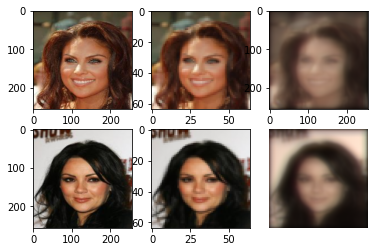

  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.21793416190020581  d2_loss:0.20390377811929014
genLoss: 21.045873865168144  vggLoss: 0.04672561942579898  MeanLoss: 0.0010169667422157177


  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.2069339412958064  d2_loss:0.21983521748730478
genLoss: 21.8562845067775  vggLoss: 0.04676058072041958  MeanLoss: 0.0010336528549545465


100%|██████████| 47/47 [01:00<00:00,  1.28s/it]


d1_loss: 0.20015394037708323  d2_loss:0.1907355677574239
genLoss: 22.025892521472688  vggLoss: 0.04665962717634566  MeanLoss: 0.0010145332495820648


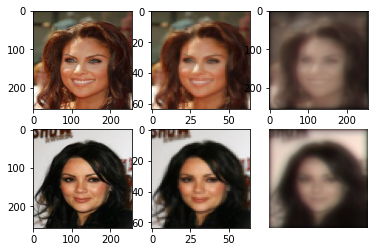

  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.21819325171886605  d2_loss:0.232213187090894
genLoss: 21.720697139171843  vggLoss: 0.04659092941499771  MeanLoss: 0.0010101074412306572


  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.216149203320767  d2_loss:0.19936564770784784
genLoss: 22.40522575378418  vggLoss: 0.04649100452661514  MeanLoss: 0.001019934802861052


100%|██████████| 47/47 [01:00<00:00,  1.28s/it]


d1_loss: 0.20759101223913914  d2_loss:0.20778695763425625
genLoss: 22.254688506430767  vggLoss: 0.046376652302260096  MeanLoss: 0.0009743641960394985


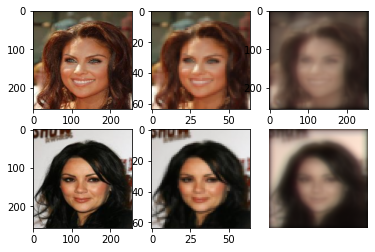

  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.21147542399294833  d2_loss:0.21213219330665914
genLoss: 22.06761948605801  vggLoss: 0.04638938003398003  MeanLoss: 0.001053124018498954


  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.20469446210785114  d2_loss:0.20008356314390263
genLoss: 21.683860230953137  vggLoss: 0.0461809940319112  MeanLoss: 0.0009787761125753217


100%|██████████| 47/47 [01:00<00:00,  1.28s/it]


d1_loss: 0.20824985063456475  d2_loss:0.1949499840749071
genLoss: 22.3953079872943  vggLoss: 0.04614815195190146  MeanLoss: 0.0010164552987454102


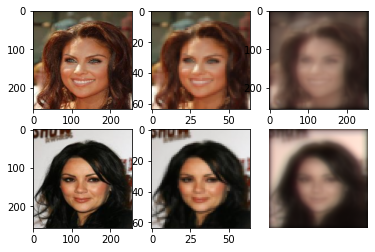

  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.2127272531073144  d2_loss:0.2123301720365565
genLoss: 22.051749249722096  vggLoss: 0.046157987669427344  MeanLoss: 0.001021461324776186


  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.21042540241429147  d2_loss:0.205483134756697
genLoss: 23.058551220183677  vggLoss: 0.04601594916683562  MeanLoss: 0.0009739515483082133


100%|██████████| 47/47 [01:00<00:00,  1.28s/it]


d1_loss: 0.20746365300518402  d2_loss:0.21931299186767417
genLoss: 22.789416536371757  vggLoss: 0.045859840084263616  MeanLoss: 0.000952910003995404


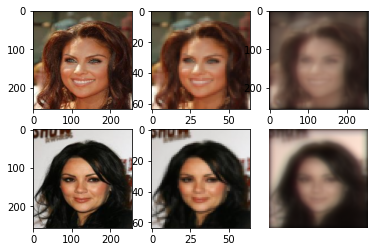

  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.21516127377114397  d2_loss:0.20568322723216198
genLoss: 22.320228576660156  vggLoss: 0.04584525018296343  MeanLoss: 0.0009425560438490294


  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.22391967316891284  d2_loss:0.2050213078235058
genLoss: 21.835997439445332  vggLoss: 0.0458822581679263  MeanLoss: 0.0009417956152514733


100%|██████████| 47/47 [01:00<00:00,  1.28s/it]


d1_loss: 0.20765561150743606  d2_loss:0.21015676079278298
genLoss: 22.906042443945054  vggLoss: 0.04589082918902661  MeanLoss: 0.0009340961498426313


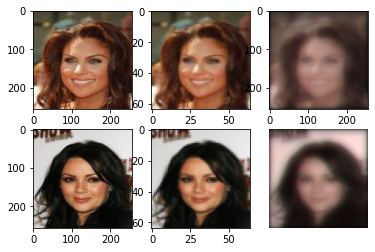

  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.19284376216695664  d2_loss:0.20304687448004458
genLoss: 23.226902170384182  vggLoss: 0.04574186719478445  MeanLoss: 0.0009368324077668343


  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.22411546301334462  d2_loss:0.21667492643315742
genLoss: 21.686311721801758  vggLoss: 0.0456635094386466  MeanLoss: 0.0009629321940976413


100%|██████████| 47/47 [01:00<00:00,  1.28s/it]


d1_loss: 0.22635611416177548  d2_loss:0.22385141538812758
genLoss: 22.56195788687848  vggLoss: 0.045578145758902774  MeanLoss: 0.0009425827363961713


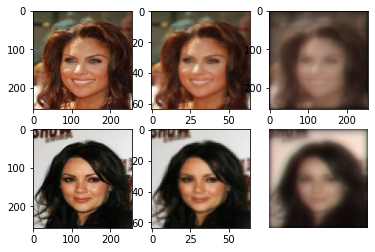

  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.2012703868936985  d2_loss:0.21377855032048326
genLoss: 23.60875003895861  vggLoss: 0.04570225634156389  MeanLoss: 0.0009895594173824375


  0%|          | 0/47 [00:00<?, ?it/s]

d1_loss: 0.19791105817607108  d2_loss:0.19455359685928264
genLoss: 23.789320377593345  vggLoss: 0.045505621252541845  MeanLoss: 0.0009822938628395663


100%|██████████| 47/47 [01:00<00:00,  1.28s/it]


d1_loss: 0.2120022528032039  d2_loss:0.22055974285653296
genLoss: 23.09358046917205  vggLoss: 0.04538652491062246  MeanLoss: 0.0008957329097184095


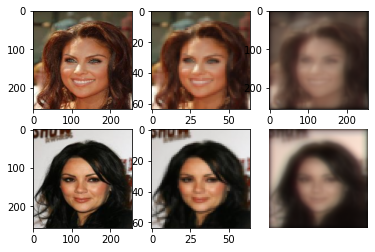

 38%|███▊      | 18/47 [00:23<00:37,  1.28s/it]

In [ ]:
#batch_count=60
epochs = 100

for epoch in range(epochs):
    d1loss_list=[]
    d2loss_list=[]
    gloss_list=[]
    vloss_list=[]
    mloss_list=[]
    
    for lr_images, hr_images in tqdm(training_generator):
                
        disc.zero_grad()

        gen_out = gen(lr_images)
        _,f_label = disc(gen_out)
        _,r_label = disc(hr_images)

        d1_loss = (disc_loss(f_label,torch.zeros_like(f_label,dtype=torch.float)))
        d2_loss = (disc_loss(r_label,torch.ones_like(r_label,dtype=torch.float)))
        d2_loss.backward()
        d1_loss.backward(retain_graph=True)
        disc_optimizer.step()

        gen.zero_grad()      
        g_loss = gen_loss(f_label.data,torch.ones_like(f_label,dtype=torch.float))
        v_loss = vgg_loss(vgg.features[:7](gen_out),vgg.features[:7](hr_images))
        m_loss = mse_loss(gen_out,hr_images)
        
        generator_loss = g_loss + v_loss + m_loss
        generator_loss.backward()
        gen_optimizer.step()
        
        d1loss_list.append(d1_loss.item())
        d2loss_list.append(d2_loss.item())
        
        gloss_list.append(g_loss.item())
        vloss_list.append(v_loss.item())
        mloss_list.append(m_loss.item())

    print("d1_loss: "+str(np.mean(d1loss_list))+"  d2_loss:"+str(np.mean(d2loss_list)))
    print("genLoss: "+str(np.mean(gloss_list))+"  vggLoss: "+str(np.mean(vloss_list))+"  MeanLoss: "+str(np.mean(mloss_list)))
    
    if(epoch%3==0):
        
        checkpoint = {'model': Generator(),
              'input_size': 64,
              'output_size': 256,
              'state_dict': gen.state_dict()}
        torch.save(checkpoint,os.path.join(weight_file,"SR"+str(epoch+1)+".pth"))
        torch.cuda.empty_cache()
        
        show_samples(images[-2:],os.path.join(weight_file,"SR"+str(epoch+1)+".pth"))